# Klasyfikacja chorób na zbiorze ChestMNIST

## Przygotowanie środowiska

In [119]:
import torch
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import optuna

from medmnist import ChestMNIST

from torch import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models

from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, accuracy_score, precision_recall_curve, roc_curve, auc, classification_report, precision_recall_fscore_support

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [53]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

device(type='cuda')

## Przygotowanie danych

### Zdefiniowanie pipeline`ów modyfikujących dane

In [54]:
norm_mean = [0.5056, 0.5056, 0.5056]
norm_std = [0.252, 0.252, 0.252]

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

### Pobranie danych

In [55]:
train_ds = ChestMNIST(root='./data', split='train', size=224, transform=train_transform, download=True)
validation_ds = ChestMNIST(root='./data', split='val', size=224, transform=val_test_transform, download=True)
test_ds = ChestMNIST(root='./data', split='test', size=224, transform=val_test_transform, download=True)

### Zdefiniowanie listy etykiet

In [56]:
NUM_CLASSES = 14

CLASS_NAMES = [
    "Atelectasis", 
    "Cardiomegaly", 
    "Effusion", 
    "Infiltration",
    "Mass", 
    "Nodule", 
    "Pneumonia", 
    "Pneumothorax",
    "Consolidation", 
    "Edema", 
    "Emphysema", 
    "Fibrosis",
    "Pleural_Thickening", 
    "Hernia"
]

### Wyświetlenie przykładowych obrazów

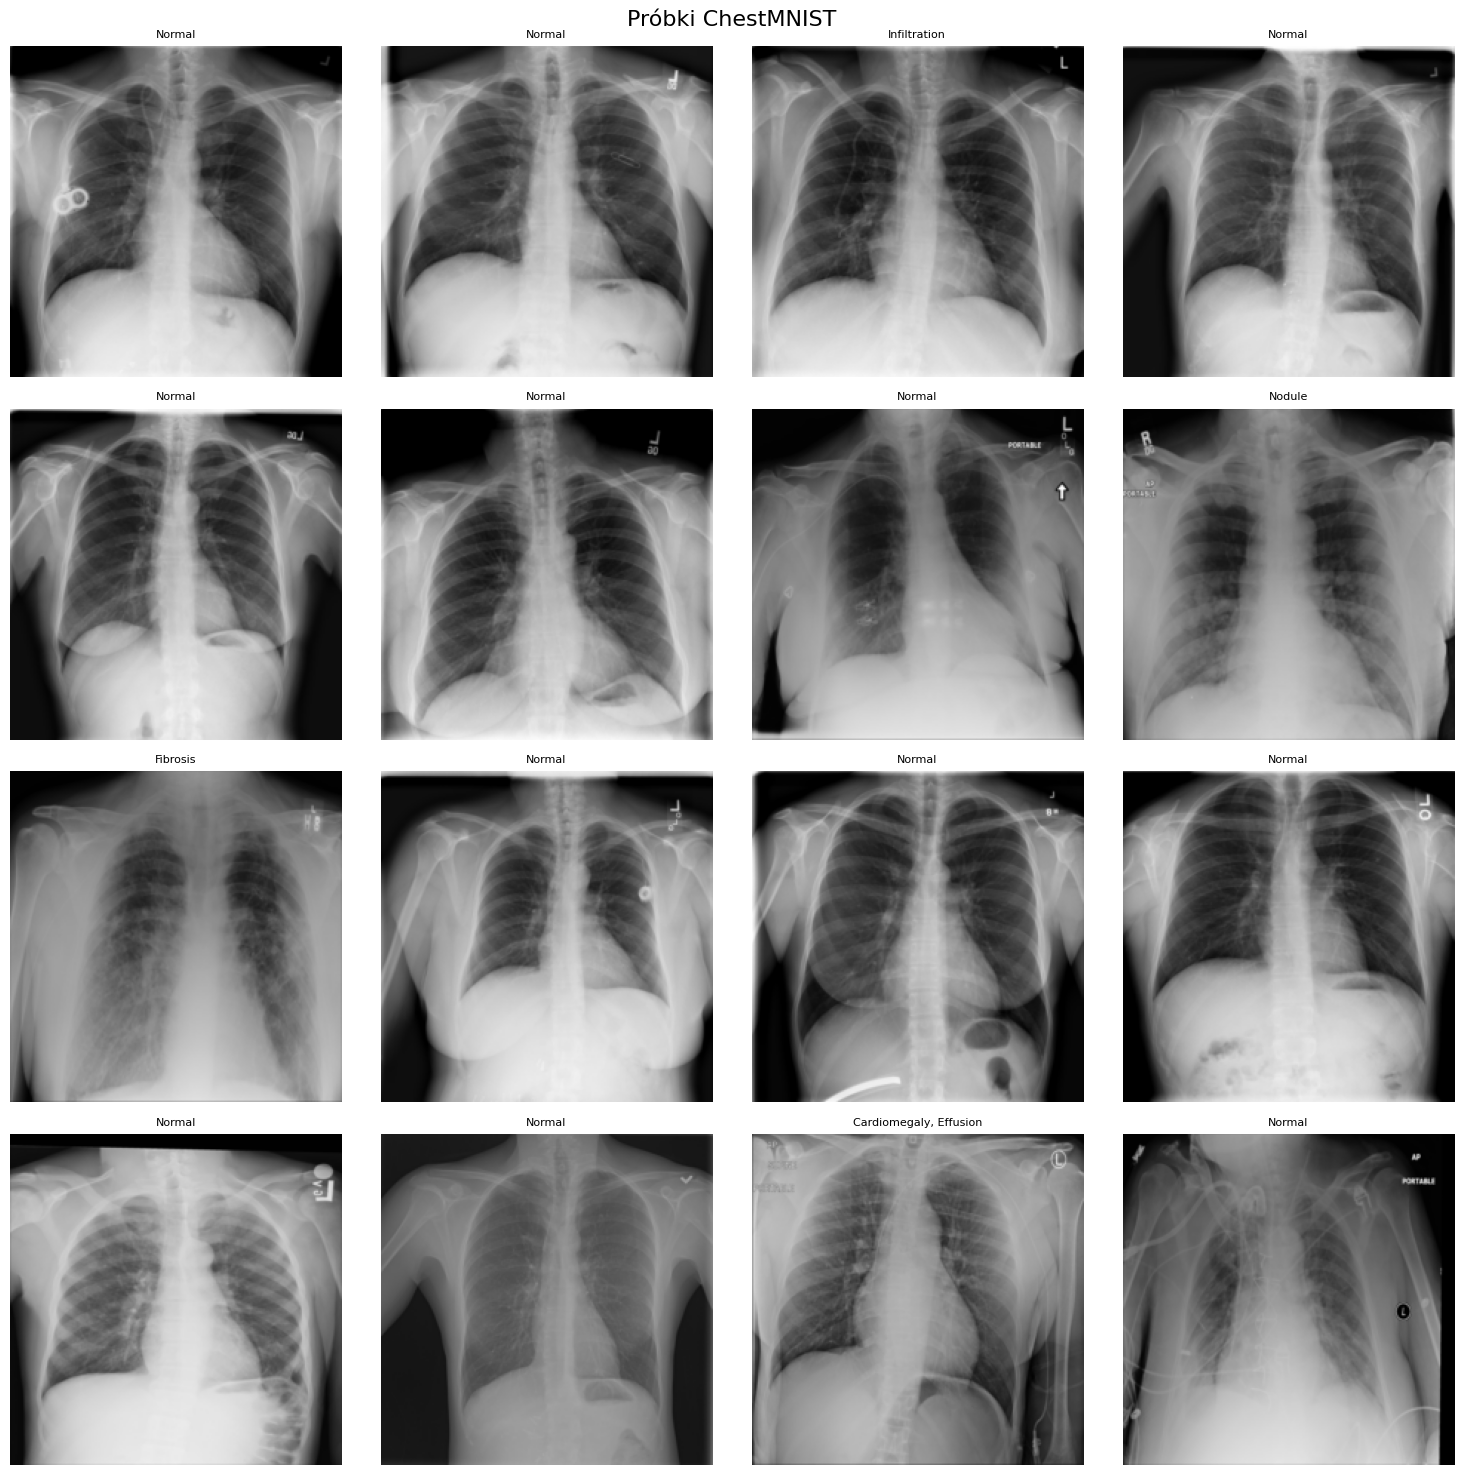

In [58]:
mean = np.array([0.5056, 0.5056, 0.5056])
std = np.array([0.252, 0.252, 0.252])

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()

for i in range(16):
    img, label = test_ds[i]

    img = img.permute(1, 2, 0).numpy()
    
    img = std * img + mean
    
    img = np.clip(img, 0, 1)

    active_classes = [
        CLASS_NAMES[j] for j, v in enumerate(label) if v == 1
    ]

    title = ", ".join(active_classes) if active_classes else "Normal"

    axes[i].imshow(img)
    axes[i].set_title(title, fontsize=8)
    axes[i].axis("off")

plt.suptitle("Próbki ChestMNIST", fontsize=16)
plt.tight_layout()
plt.show()

### Rozkład klas 

In [59]:
def analyze_class_counts(dataset, class_names):
    all_labels = dataset.labels
    class_counts = np.sum(all_labels, axis=0)
    
    df = pd.DataFrame({
        "Klasa": class_names,
        "Liczba próbek": class_counts.astype(int),
        "Udział %": (class_counts / len(dataset) * 100).round(2)
    })
    
    df = df.sort_values(by="Liczba próbek", ascending=False)
    
    return df

In [60]:
def plot_class_dist(dataset, title):
    plt.figure(figsize=(12, 6))
    plt.bar(dataset["Klasa"], dataset["Liczba próbek"], color='darkblue', label="Liczba próbek")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

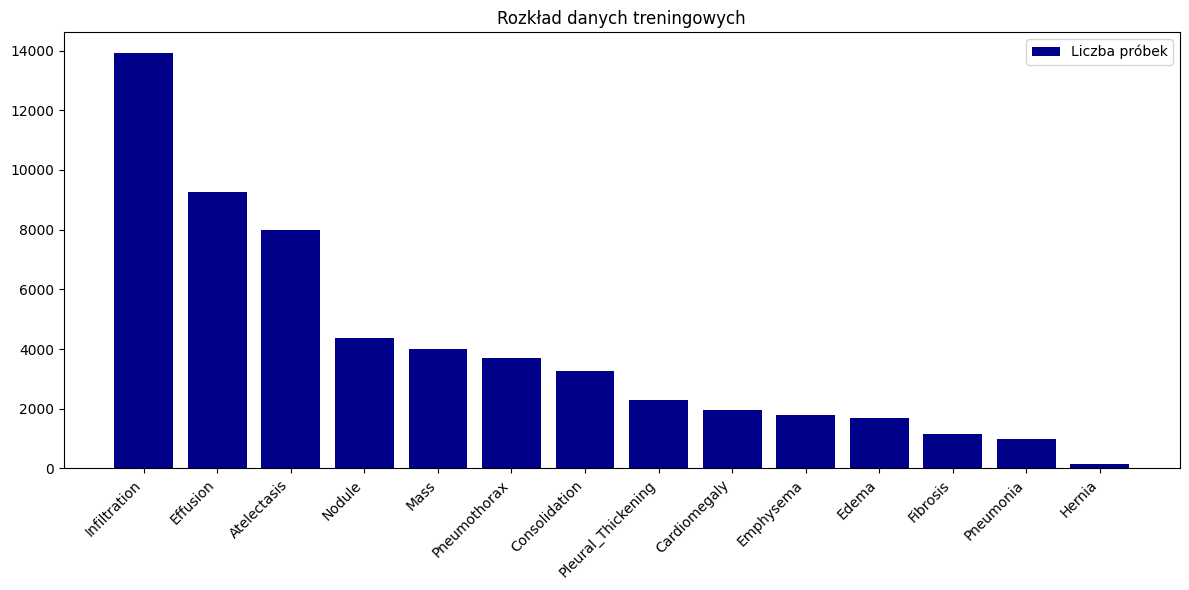

Wielkość zbioru treningowego: 78468 próbek


In [61]:
df_train = analyze_class_counts(train_ds, CLASS_NAMES)

plot_class_dist(df_train, 'Rozkład danych treningowych')
print('Wielkość zbioru treningowego:', len(train_ds), 'próbek')

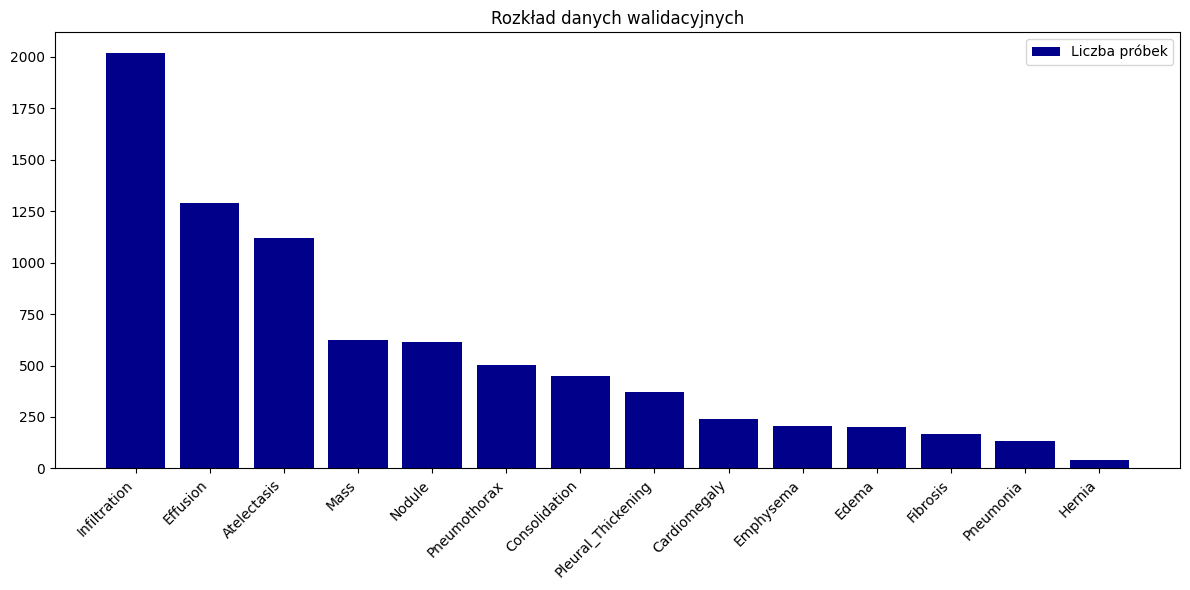

Wielkość zbioru walidacyjnego: 11219 próbek


In [62]:
df_val = analyze_class_counts(validation_ds, CLASS_NAMES)

plot_class_dist(df_val, 'Rozkład danych walidacyjnych')
print('Wielkość zbioru walidacyjnego:', len(validation_ds), 'próbek')

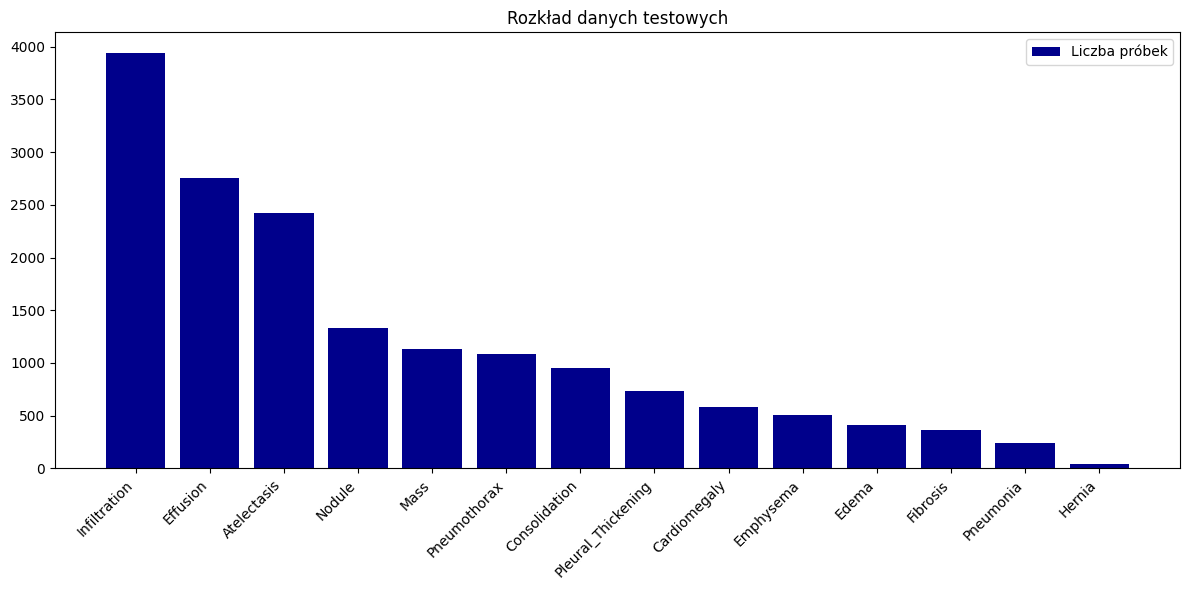

Wielkość zbioru walidacyjnego: 22433 próbek


In [63]:
df_test = analyze_class_counts(test_ds, CLASS_NAMES)

plot_class_dist(df_test, 'Rozkład danych testowych')
print('Wielkość zbioru walidacyjnego:', len(test_ds), 'próbek')

## Trenowanie modelu

### Zdefiniowanie DataLoader`ów

In [64]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    validation_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

### Funkcje pomocnicze dla metryk ACC i AUC

In [65]:
def get_auc(labels, preds):
    auc = 0
    for i in range(labels.shape[1]):
        auc += roc_auc_score(labels[:, i], preds[:, i])
    
    return auc / preds.shape[1]

def get_acc(labels, preds, threshold=0.5):
    acc = 0.0 

    one_zero_preds = (preds > threshold).astype(int)
    for label in range(preds.shape[1]):
        acc += accuracy_score(labels[:, label], one_zero_preds[:, label])

    return acc / preds.shape[1]

### Funkcja pomocnicza odpowiedzialna za wykonanie kroku treningowego

In [66]:
def train_step(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)         

        optimizer.zero_grad()
        outputs = model(inputs)                     
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    epoch_loss = sum(total_loss) / len(total_loss)

    return epoch_loss

### Funkcja pomocnicza odpowiedzialna za walidacje

In [67]:
@torch.no_grad()
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = []
    all_labels = []
    all_preds = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        
        outputs = model(inputs.to(device))

        loss = criterion(outputs, labels)

        preds = torch.sigmoid(outputs)

        total_loss.append(loss.item())
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

    val_loss = np.mean(total_loss)

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    auc = get_auc(all_labels, all_preds)
    acc = get_acc(all_labels, all_preds)

    return val_loss, auc, acc, all_preds

### Pętla treningowa

In [68]:
PATIENCE = 10

def train_loop(model, train_ds, val_ds, optimizer, criterion, scheduler, epochs, device):
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    val_accs = []
    val_aucs = []

    for epoch in range(epochs):
        start_t = time.time()

        train_loss = train_step(model, train_ds, optimizer, criterion, device)
        val_loss, val_auc, val_acc, _  = validate(model, val_ds, criterion, device)

        end_t = time.time()
        duration = end_t - start_t
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_aucs.append(val_auc)

        scheduler.step(val_loss)

        m, s = divmod(duration, 60)
        width = len(str(epochs))

        print(
            f"Epoch [{epoch+1:>{width}}/{epochs}] | "
            f"Learning Rate: {optimizer.param_groups[0]['lr']:.1e} | "
            f"Time: {int(m)}m {int(s)}s | "      
            f"Train loss: {train_loss:.4f} | "
            f"Val loss: {val_loss:.4f} | Val ACC: {val_acc:.4f} | Val AUC: {val_auc:.4f}"
        )
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_classic_cnn.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            print("Early Stop")
            break

    return { 'train_loss': train_losses, 'val_loss': val_losses, 'val_acc': val_accs, 'val_auc': val_aucs } 

### Model konwolucyjnej sieci neuronowej

#### Klasa bloku konwolucyjnego

In [69]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding, stride=1, activation_name="ReLU"):    
        super().__init__()
        
        if activation_name == "ReLU":
            activation = nn.ReLU(inplace=True)
        elif activation_name == "LeakyReLU":
            activation = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        elif activation_name == "GELU":
            activation = nn.GELU()

        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(out_ch),
            activation
        )

    def forward(self, x):
        return self.block(x)

#### Model głębokiej sieci konwolucyjnej poddanej optymalizacji

In [70]:
DROPOUT_RATE_MIN = 0.1
DROPOUT_RATE_MAX = 0.5
ACTIVATION_FUNCS = ["ReLU", "LeakyReLU", "GELU"]
BASE_CHANNELS = [16, 32, 64]

class OptimCNN(nn.Module):                                   
    def __init__(self, trial, in_channels=3, num_labels=14):
        super().__init__()
        
        dropout_rate = trial.suggest_float("dropout_rate", DROPOUT_RATE_MIN, DROPOUT_RATE_MAX)
        act_name = trial.suggest_categorical("activation", ACTIVATION_FUNCS)
        base_channels = trial.suggest_categorical("base_filters", BASE_CHANNELS)
        
        self.features = nn.Sequential(
            ConvBlock(in_channels, base_channels, kernel_size=3, padding=1, stride=1, activation_name=act_name),   
            ConvBlock(base_channels, base_channels*2, kernel_size=3, padding=1, stride=2, activation_name=act_name),            
            ConvBlock(base_channels*2, base_channels*4, kernel_size=3, padding=1, stride=2, activation_name=act_name),           
            ConvBlock(base_channels*4, base_channels*8, kernel_size=3, padding=1, stride=2, activation_name=act_name),          
            ConvBlock(base_channels*8, base_channels*16, kernel_size=3, padding=1, stride=2, activation_name=act_name),
            ConvBlock(base_channels*16, base_channels*16, kernel_size=3, padding=1, stride=2, activation_name=act_name),          
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(base_channels*16, num_labels)
        )    

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

### Optymalizacja

#### Przygotowanie DataLoader`ów

In [71]:
def get_dataloarders(batch_size):
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(
        validation_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader

In [74]:
BATCH_SIZES = [16, 32, 64]
WEIGHT_DECAYS = [1e-5, 1e-3]
LRS = [1e-4, 1e-3]
OPTIMIZERS = ["Adam", "AdamW", "SGD"]

def objective(trial):
    model = OptimCNN(trial, in_channels=3, num_labels=14).to(DEVICE)
    
    lr = trial.suggest_float("lr", LRS[0], LRS[1], log=True) 
    weight_decay = trial.suggest_float("weight_decay", WEIGHT_DECAYS[0], WEIGHT_DECAYS[1], log=True)   
    batch_size = trial.suggest_categorical("batch_size", BATCH_SIZES)
    optimizer_name = trial.suggest_categorical("optimizer", OPTIMIZERS)
    
    train_loader, val_loader = get_dataloarders(batch_size)

    criterion = nn.BCEWithLogitsLoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.1, 
        patience=5
    )

    best_auc = 0.0
    epochs = 10

    for epoch in range(epochs):
        _ = train_step(model, train_loader, optimizer, criterion, DEVICE)
        val_loss, val_auc, _, _  = validate(model, val_loader, criterion, DEVICE)

        scheduler.step(val_loss)

        trial.report(val_auc, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        best_auc = max(best_auc, val_auc)

    return best_auc

study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)   

[I 2026-01-24 12:09:00,710] A new study created in memory with name: no-name-d8404b4b-5387-4949-9ff2-62580d8a26a9


In [76]:
study.optimize(objective, n_trials=25)

print("Best AUC:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"{k}: {v}") 

[I 2026-01-24 12:25:42,834] Trial 1 finished with value: 0.743462840951863 and parameters: {'dropout_rate': 0.48560080805747785, 'activation': 'ReLU', 'base_filters': 32, 'lr': 0.0001619183587561619, 'weight_decay': 8.465981032716332e-05, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.743462840951863.
[I 2026-01-24 12:35:17,306] Trial 2 finished with value: 0.7549582559478915 and parameters: {'dropout_rate': 0.32576429391319195, 'activation': 'ReLU', 'base_filters': 16, 'lr': 0.0001553123737652484, 'weight_decay': 1.7012347958691597e-05, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7549582559478915.
[I 2026-01-24 12:45:00,997] Trial 3 finished with value: 0.6276088428056695 and parameters: {'dropout_rate': 0.2089817382783815, 'activation': 'GELU', 'base_filters': 16, 'lr': 0.0002635903540291874, 'weight_decay': 1.8977884568329302e-05, 'batch_size': 32, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.7549582559478915.
[I 2026-01-24 13:0

Best AUC: 0.7798848866742879
Best params:
dropout_rate: 0.18862545592368024
activation: GELU
base_filters: 64
lr: 0.00010356531781870888
weight_decay: 0.0003140895080685686
batch_size: 16
optimizer: AdamW


In [79]:
class CNN(nn.Module):                                   
    def __init__(self, in_channels=3, num_labels=14):
        super().__init__()

        act_name='GELU'
        base_channels=64
        dropout_rate=0.2      
        
        self.features = nn.Sequential(
            ConvBlock(in_channels, base_channels, kernel_size=3, padding=1, stride=1, activation_name=act_name),   
            ConvBlock(base_channels, base_channels*2, kernel_size=3, padding=1, stride=2, activation_name=act_name),            
            ConvBlock(base_channels*2, base_channels*4, kernel_size=3, padding=1, stride=2, activation_name=act_name),           
            ConvBlock(base_channels*4, base_channels*8, kernel_size=3, padding=1, stride=2, activation_name=act_name),          
            ConvBlock(base_channels*8, base_channels*16, kernel_size=3, padding=1, stride=2, activation_name=act_name),
            ConvBlock(base_channels*16, base_channels*16, kernel_size=3, padding=1, stride=2, activation_name=act_name),          
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(base_channels*16, num_labels)
        )    

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [80]:
model = CNN().to(DEVICE)

adamw = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=3e-4)
bce = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    adamw, 
    mode='min', 
    factor=0.1, 
    patience=5
)

In [81]:
EPOHCS = 50

model_results = train_loop(
    model=model,
    train_ds=train_loader,
    val_ds=val_loader,
    optimizer=adamw,
    criterion=bce,
    scheduler=scheduler,
    epochs=50,
    device=DEVICE
)

Epoch [ 1/50] | Learning Rate: 1.0e-04 | Time: 3m 53s | Train loss: 0.1799 | Val loss: 0.1719 | Val ACC: 0.9492 | Val AUC: 0.6671
Epoch [ 2/50] | Learning Rate: 1.0e-04 | Time: 3m 55s | Train loss: 0.1715 | Val loss: 0.1685 | Val ACC: 0.9490 | Val AUC: 0.7135
Epoch [ 3/50] | Learning Rate: 1.0e-04 | Time: 3m 54s | Train loss: 0.1685 | Val loss: 0.1664 | Val ACC: 0.9492 | Val AUC: 0.7328
Epoch [ 4/50] | Learning Rate: 1.0e-04 | Time: 3m 54s | Train loss: 0.1667 | Val loss: 0.1662 | Val ACC: 0.9491 | Val AUC: 0.7329
Epoch [ 5/50] | Learning Rate: 1.0e-04 | Time: 3m 54s | Train loss: 0.1654 | Val loss: 0.1623 | Val ACC: 0.9492 | Val AUC: 0.7560
Epoch [ 6/50] | Learning Rate: 1.0e-04 | Time: 3m 55s | Train loss: 0.1643 | Val loss: 0.1610 | Val ACC: 0.9494 | Val AUC: 0.7614
Epoch [ 7/50] | Learning Rate: 1.0e-04 | Time: 3m 54s | Train loss: 0.1633 | Val loss: 0.1610 | Val ACC: 0.9492 | Val AUC: 0.7652
Epoch [ 8/50] | Learning Rate: 1.0e-04 | Time: 3m 55s | Train loss: 0.1624 | Val loss: 0.1

### Wykresy funkcjia straty, ACC, AUC

In [88]:
def plot_history(history):
    epochs = range(1, EPOHCS + 1)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label="Funkcja straty na danych treningowych")
    plt.plot(epochs, history['val_loss'], label="Funkcja straty na danych walidacyjnych")
    plt.xlabel("Epoka")
    plt.ylabel("Błąd")
    plt.title("Funkcja straty w zależności od epoki")
    plt.legend()

    # plt.subplot(1, 3, 2)
    # plt.plot(epochs, history['val_acc'], label="Dokładność na danych walidacyjnych")
    # plt.xlabel("Epoka")
    # plt.ylabel("Dokładność")
    # plt.title("Dokładność w zależności od epoki")
    # plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_auc'], label="AUC na danych walidacyjnych")
    plt.xlabel("Epoka")
    plt.ylabel("AUC")
    plt.title("AUC w zależności od epoki")
    plt.legend()

    plt.tight_layout()
    plt.show()

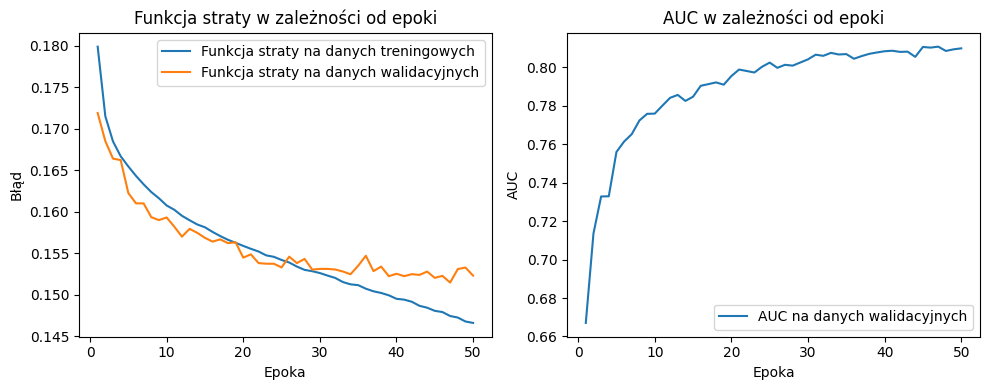

In [89]:
plot_history(model_results)

## Ewaluacja

In [90]:
restored_model = CNN().to(DEVICE)

restored_model.load_state_dict(state_dict=torch.load('models/best_model.pth', weights_only=True))

<All keys matched successfully>

In [91]:
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    
    all_labels = []
    all_preds = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        
        all_labels.append(labels.numpy())

        outputs = model(inputs)
        preds = torch.sigmoid(outputs)

        all_preds.append(preds.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    auc = get_auc(all_labels, all_preds)
    acc = get_acc(all_labels, all_preds)

    return auc, acc, all_preds, all_labels

In [96]:
test_auc, test_acc, y_preds, y_true = evaluate(restored_model, test_loader, DEVICE)

print(f"Test AUC: {test_auc:6f}")
print(f"Test ACC: {test_acc:6f}")

Test AUC: 0.809179
Test ACC: 0.947873


In [93]:
def plot_roc_grid(labels, preds, class_names):
    num_classes = labels.shape[1]
    
    cols = 4
    rows = math.ceil(num_classes / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3.5))
    axes = axes.flatten()

    for i in range(num_classes):
        ax = axes[i]
        
        fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
        roc_auc = auc(fpr, tpr)
            
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')

        ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{class_names[i]}')
        ax.legend(loc="lower right")
        ax.grid(alpha=0.3)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

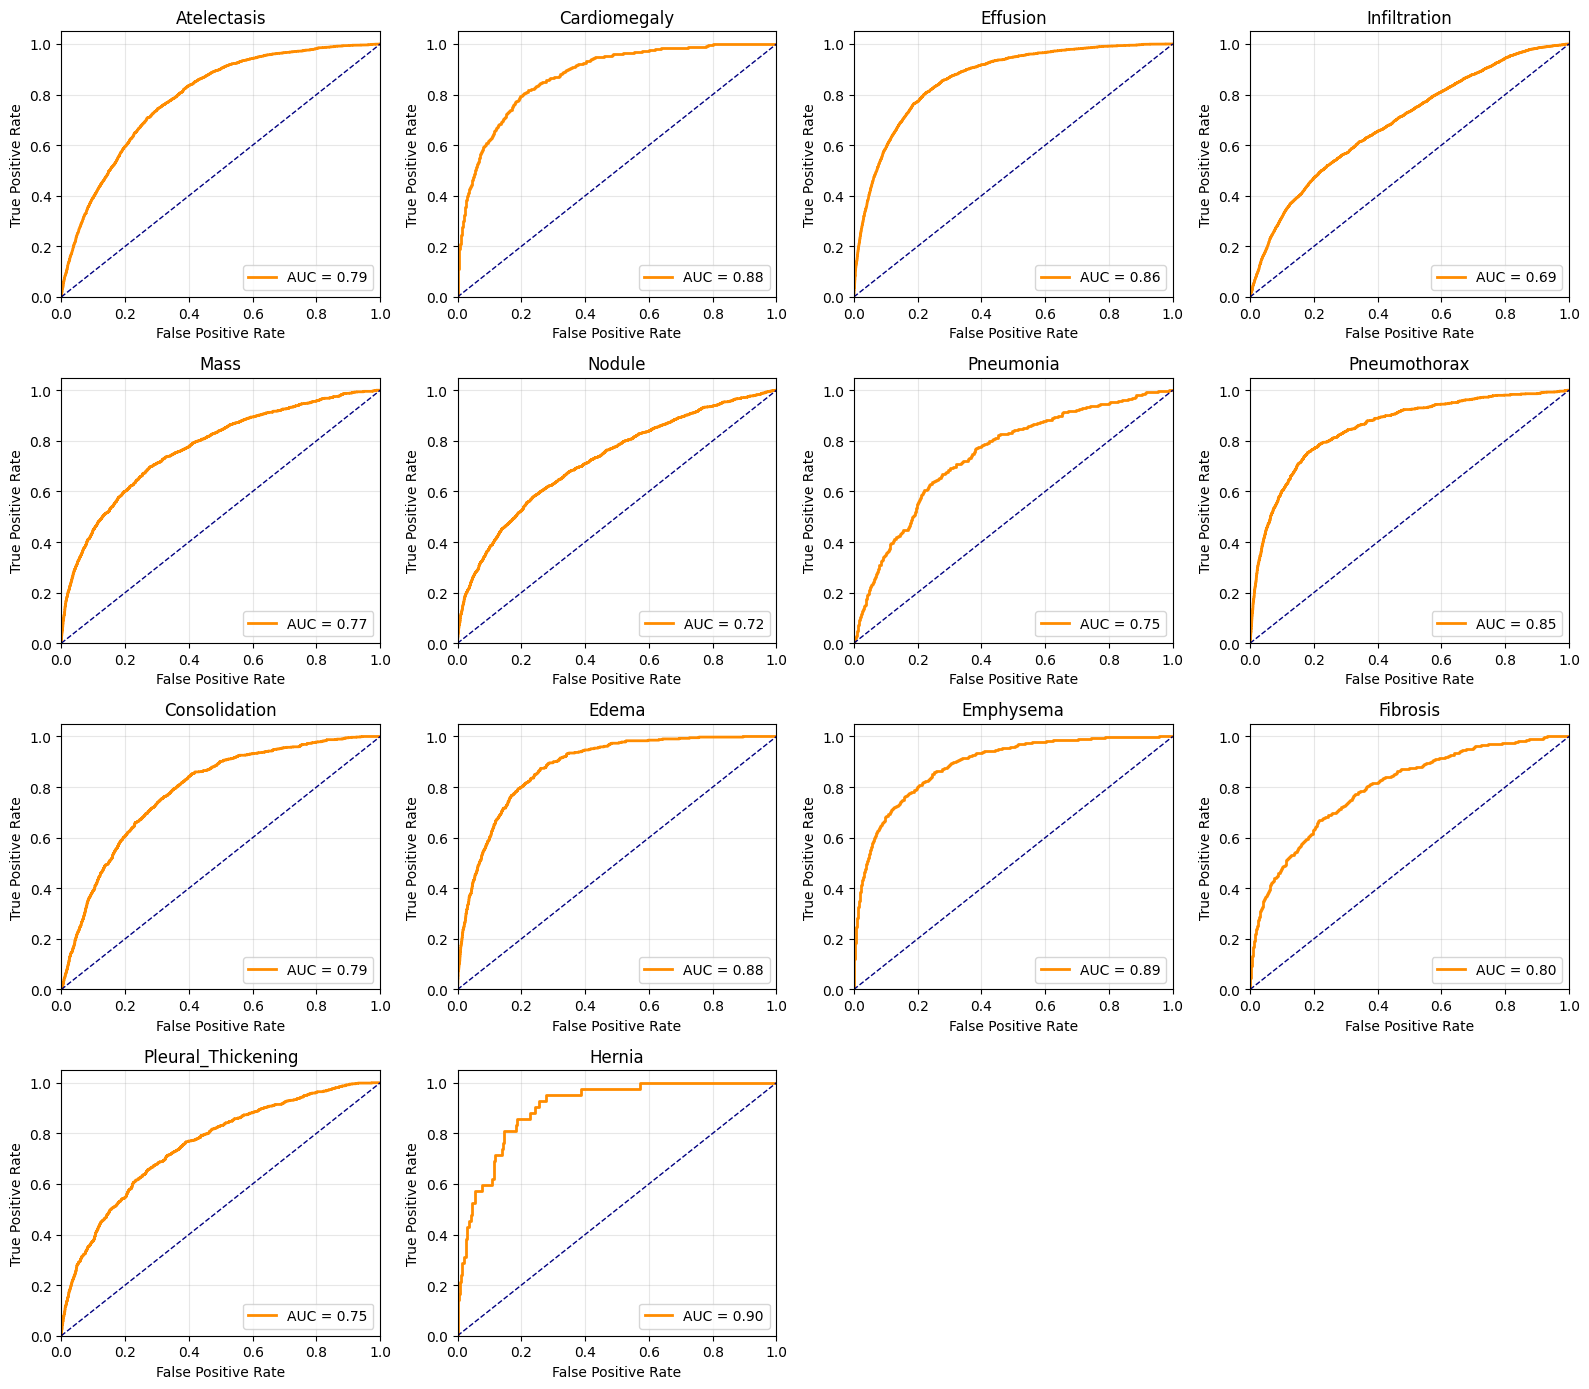

In [98]:
plot_roc_grid(y_true, y_preds, CLASS_NAMES)

In [121]:
def find_optimal_thresholds(y_true, y_preds):
    optimal_thresholds = []
    best_f1_scores = []
    
    for i in range(y_true.shape[1]):
        precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_preds[:, i])
        
        numerator = 2 * precision * recall
        denominator = precision + recall
        
        f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
        
        best_idx = np.argmax(f1_scores)
        best_thresh = thresholds[best_idx]
        best_f1 = f1_scores[best_idx]
        
        optimal_thresholds.append(best_thresh)
        best_f1_scores.append(best_f1)
        
    return optimal_thresholds, best_f1_scores

thresholds, f1s = find_optimal_thresholds(y_true, y_preds)
y_pred_binary = (y_preds > thresholds).astype(int)

In [130]:
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_binary, average='samples', zero_division=1)

print(f"Precision: {precision:6f}")
print(f"Recall: {recall:6f}")
print(f"F1: {f1:6f}")

Precision: 0.624307
Recall: 0.737215
F1: 0.502836


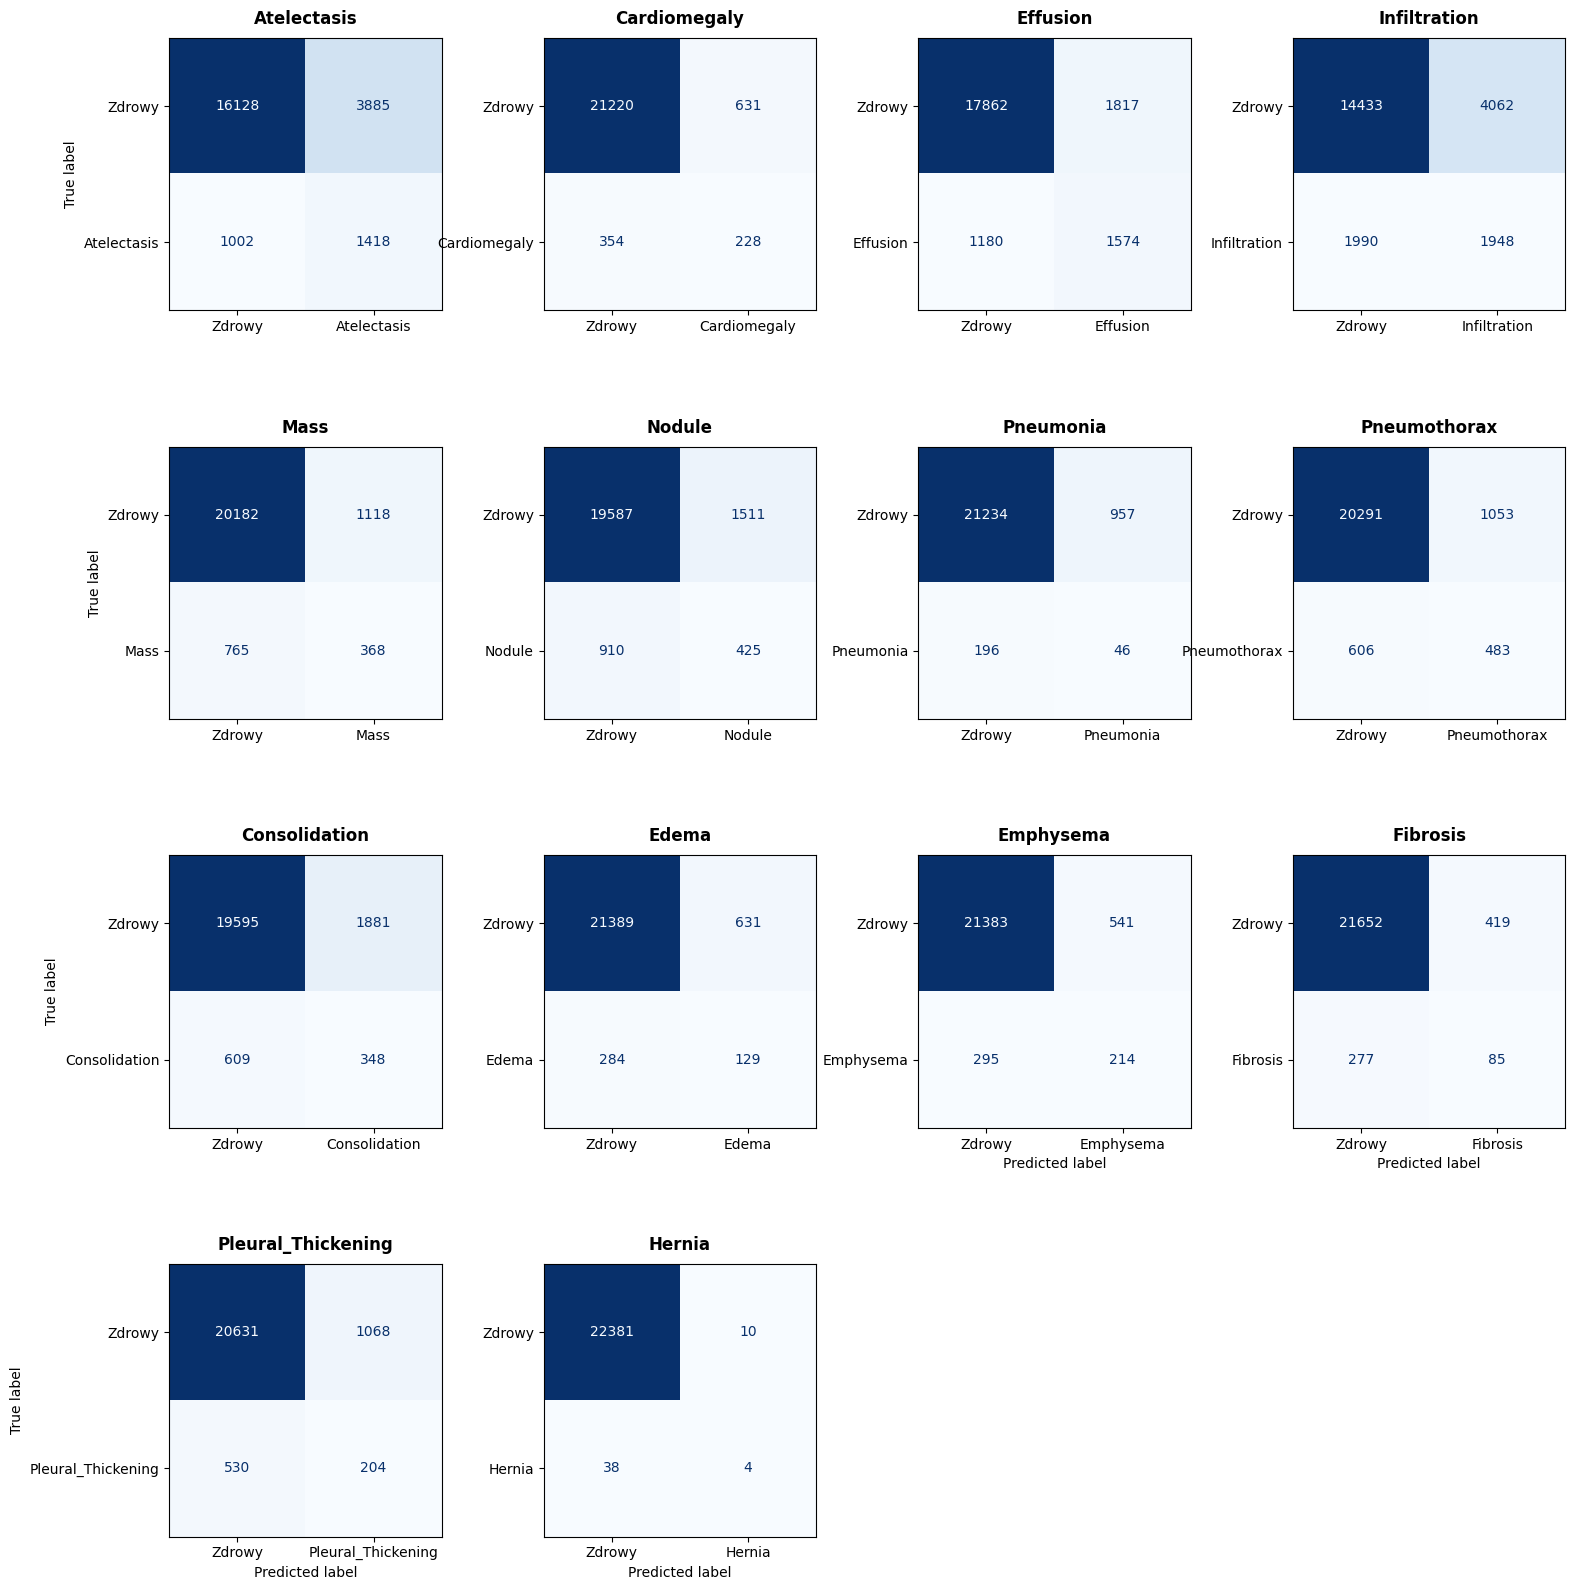

In [123]:
n_classes = y_pred_binary.shape[1]
n_cols = 4 
n_rows = math.ceil(n_classes / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i in range(n_classes):
    cm_display = ConfusionMatrixDisplay.from_predictions(
        y_true[:, i],
        y_pred_binary[:, i],
        display_labels=["Zdrowy", CLASS_NAMES[i]],
        cmap='Blues',
        ax=axes[i],
        colorbar=False,
        values_format='d'
    )
    
    axes[i].set_title(f"{CLASS_NAMES[i]}", fontsize=12, fontweight='bold', pad=10)
    
    if i % n_cols != 0:
        axes[i].set_ylabel('')
    if i < (n_rows - 1) * n_cols and (i + n_cols) < n_classes:
        axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

## Wizualizacja Grad-CAM

In [115]:
def visualize_gradcam_batch(
    model,
    dataset,
    start_index,
    num_images,
    device,
    target_class_idx=None
):
    model.eval()
    model.to(device)

    MEAN = 0.5056
    STD = 0.252

    target_layers = [model.features[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)

    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))

    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        idx = start_index + i
        img_tensor, label = dataset[idx]
        img_tensor = img_tensor.unsqueeze(0).to(device)

        if target_class_idx is None:
            outputs = model(img_tensor)
            class_idx = torch.argmax(outputs, dim=1).item()
        else:
            class_idx = target_class_idx

        targets = [ClassifierOutputTarget(class_idx)]

        grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        rgb_img = img_tensor.cpu().squeeze().numpy()

        if len(rgb_img.shape) == 3:
            rgb_img = rgb_img[0, :, :]

        rgb_img = (rgb_img * STD) + MEAN
        rgb_img = np.clip(rgb_img, 0, 1)

        rgb_img_color = np.stack((rgb_img,) * 3, axis=-1)

        visualization = show_cam_on_image(
            rgb_img_color, grayscale_cam, use_rgb=True
        )

        axes[i].imshow(visualization)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


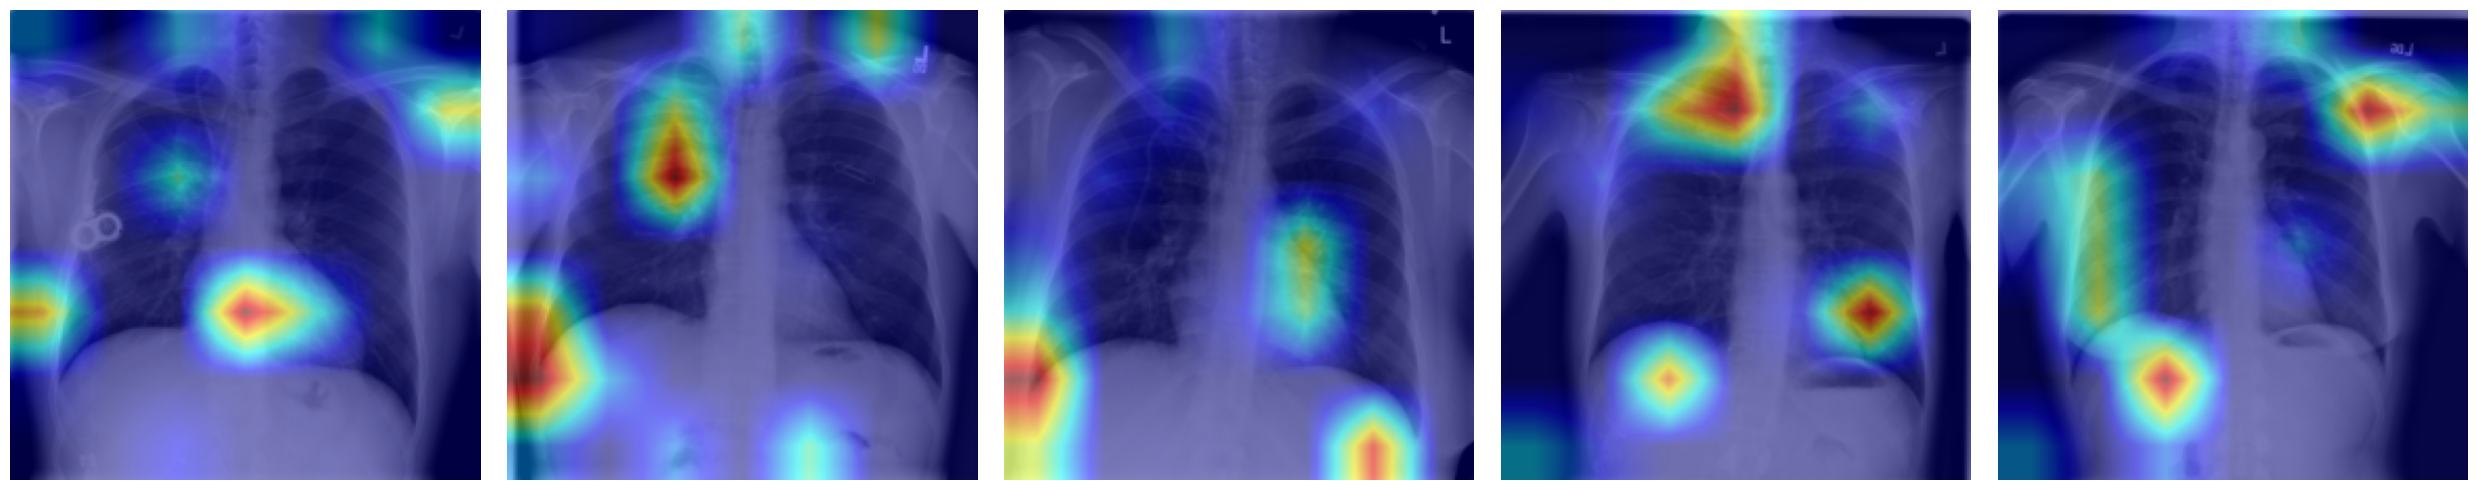

In [116]:
visualize_gradcam_batch(
    model=restored_model,
    dataset=test_ds,
    start_index=0,
    num_images=5,
    device=DEVICE
)